# **GCN Kipf Tf version**

## Environment Setup

In [0]:
# PENDING
!sudo apt-get install libcairo2-dev

**Cairo lib for plotting**

In [0]:
!sudo pip install cairocffi

In [0]:
!pip install pycairo networkx
#!pip install cairocffi networkx

**igraph for Python**

In [0]:
!pip install python-igraph 

##  **Download code from github repo**

In [113]:
!rm -r ./csn-project
!rm ./*.py
!rm ./*.pyc

rm: cannot remove './csn-project': No such file or directory
rm: cannot remove './*.pyc': No such file or directory


In [114]:
#from getpass import getpass
#import os

#user = getpass('Github user')
#password = getpass('Github password')
#os.environ['GIT_AUTH'] = user + ':' + password
#!git clone https://$GIT_AUTH@github.com/presmerats/csn-project.git
!git clone https://github.com/presmerats/csn-project.git
!ls -la

Cloning into 'csn-project'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 254 (delta 83), reused 232 (delta 64), pack-reused 0
Receiving objects: 100% (254/254), 7.26 MiB | 27.45 MiB/s, done.
Resolving deltas: 100% (83/83), done.
total 1964
drwxr-xr-x 1 root root    4096 Jan 22 18:15  .
drwxr-xr-x 1 root root    4096 Jan 22 16:51  ..
drwxr-xr-x 1 root root    4096 Jan  8 17:14  .config
drwxr-xr-x 5 root root    4096 Jan 22 18:15  csn-project
drwxr-xr-x 2 root root    4096 Jan 22 18:11  data
-rw-r--r-- 1 root root  201029 Jan 22 18:12  embedding
-rw-r--r-- 1 root root   78532 Jan 22 18:12  embedding_labels
-rw-r--r-- 1 root root   12448 Jan 22 18:11  index.html
-rw-r--r-- 1 root root    9162 Jan 22 18:11  InputTest-py2.ipynb
-rw-r--r-- 1 root root  249215 Jan 22 18:11  InputTest-Py3.ipynb
-rw-r--r-- 1 root root  121663 Jan 22 18:11 'PageRank Embedding Experiment.ipynb'
drwxr-xr-x

In [0]:
!cp -r ./csn-project/src/gcn/gcn_mod/gcn/* .


In [117]:
!ls

 csn-project	       layers.py
 data		       metrics.py
 embedding	       models.py
 embedding_labels     'PageRank Embedding Experiment.ipynb'
 gcn_tests_input.py    __pycache__
 index.html	       sample_data
 __init__.py	      'Tf Tutorial Traffic Signs.ipynb'
 inits.py	       train.py
 InputTest-py2.ipynb   utils.py
 InputTest-Py3.ipynb   utils.pyc


## Generating a graph and training a GCN

### Prepare graph files functions

In [0]:
# local python tests
from pprint import pprint
from igraph import *
import igraph.test
import pickle
import os
import numpy as np
from scipy.sparse import csr_matrix
import collections
import copy
from random import randint


def pickleToDisk(myobj, filepath):
    pickle.dump(myobj, open(filepath, "wb"))


def printGraphObject(filepath):


    myobject = os.path.basename(filepath)
    print("\n\n*************** "+myobject+" ********************")
    y = pickle.load(open(filepath,'rb'))
    print(type(y))
    if type(y) ==  type([]) or type(y) == type(np.ndarray([])):
        
        print(len(y))
        pprint(y[:min(3,len(y)-1)])
    elif type(y) == type({}) or type(y)==type(collections.defaultdict()):
        pprint(y.keys()[:min(3,len(y)-1)])
        pprint(y[y.keys()[0]])
        pprint(y[y.keys()[1]])
        pprint(y[y.keys()[20]])
        pprint(y[y.keys()[3000]])

    else:
        
        pprint(y.shape)
        pprint(y[0,:min(3,y.shape[1]-1)].toarray())
        pprint(y[0,0].shape)
        pprint(type(y[0,0]))
        pprint(y[0,0])

def readListFile(filepath):
    myobject = os.path.basename(filepath)
    print("\n\n*************** "+myobject+" ********************")
    

    testInstances =[]
    with open(filepath, 'rb') as f:
        for line in f.readlines():
            testInstances.append(int(line))

    pprint(testInstances[:min(3,len(testInstances)-1)])


def inspectData():

    printGraphObject('../gcn/gcn/gcn/data/ind.citeseer.y')
    printGraphObject('../gcn/gcn/gcn/data/ind.citeseer.ty')
    printGraphObject('../gcn/gcn/gcn/data/ind.citeseer.x')
    printGraphObject('../gcn/gcn/gcn/data/ind.citeseer.tx')
    printGraphObject('../gcn/gcn/gcn/data/ind.citeseer.graph')
    readListFile('../gcn/gcn/gcn/data/ind.citeseer.test.index')
    printGraphObject('../gcn/gcn/gcn/data/ind.citeseer.allx')
    printGraphObject('../gcn/gcn/gcn/data/ind.citeseer.ally')


def discretize(elements):
    """ create a binary array for each of the 10 ranges of values between 0 and 1"""
    orig = np.array(elements)
    results = []
    
    themax = np.amax(orig)
    themin = np.amin(orig)
    step = (themax - themin )/ 40.0
    
    for i in range(10):
        print(i) 
        if i<9:
            print(orig)
            print(themin + step*i)
            print(themin + step*(i+1))
            range1 = np.bitwise_and(orig >= themin + step*i , orig <= themin + step*(i+1))
        else:
            range1 = orig >= themin + step*i
        print(range1)
        results.append(range1) 
        
    result = np.transpose(np.asarray(results))
    print(result.shape)
    pprint(result)
    return result


def generateData(suffix, n_node=1000, n_test=200, n_train=300 ):
    
    #igraph.test.run_tests()

    # generation
    #g = Graph.Tree(127, 2)
    #g = Graph.GRG(100, 0.2)
    #g = Graph.Erdos_Renyi(100, 0.2)
    #g = Graph.Watts_Strogatz(1, 100, 4, 0.5 )
    g = Graph.Barabasi(n_node)
    summary(g)

    # graph metrics
    # pprint(g.degree([2,3,6,99]))
    # pprint(g.edge_betweenness())
    # pprint(g.pagerank())
    #pprint(g.get_adjacency())
    #pprint(dir(g))
    


    # test.index
    testList = [] 
    with open(suffix+'.test.index','wb') as f:
        while len(testList) < n_test:
            j = randint(0, n_node-1)
            #verify it is not alerady there
            try:
                pos = testList.index(j)
            except:
                testList.append(j)
            f.write(str.encode(str(j)+"\n"))


    # adjacency dict (graph)
    i = 0
    A = g.get_adjlist()
    graphAdj = {}
    for node in A:
        graphAdj[i] = node
        i+=1
    pickleToDisk(graphAdj, suffix+".graph")

    
    xFeatures = np.ones(n_node)
    # allx is for labeled and unlabeled training samples
    allx  = copy.deepcopy([xFeatures[i] for i in range(n_node) if i not in testList])
    # x is for labeled training samples only
    x = copy.deepcopy(allx[:-500])
    #tx = copy.deepcopy(xFeatures[range(n_node-n_test, n_node)])
    tx = [xFeatures[i] for i in testList]
    

    
    allx = csr_matrix(allx)
    allx = np.transpose(allx)
    pickleToDisk(allx, suffix+".allx")
    x = csr_matrix(x)
    x = np.transpose(x)
    pickleToDisk(x, suffix+".x")
    tx = csr_matrix(tx)
    tx = np.transpose(tx)
    pickleToDisk(tx, suffix+".tx")

    print(x.shape)
    print(tx.shape)
    print(allx.shape)
    


    # labels (ally,y , ty)
    prs = discretize(g.pagerank())

    

    # labels of x, and empty labels of unlabeled training samples
    prs_all = copy.deepcopy([prs[i] for i in range(n_node) if i not in testList])
    # labels of the labeled training samples
    prs_train = copy.deepcopy(prs_all[:-500])
    prs_test = copy.deepcopy([prs[i] for i in testList])
    #testList.extend(validationList)
    #finalList = testList
    #prs_train = [ prs[i] for i in range(prs.shape[0]) if i not in finalList ]

    ally = np.array(prs_all)
    y = np.array(prs_train)  
    ty = np.array(prs_test)


    pickleToDisk(ally, suffix+".ally")
    pickleToDisk(y, suffix+".y")
    pickleToDisk(ty, suffix+".ty")
    
    print(y.shape)
    print(ty.shape)
    print(ally.shape)
    pprint(ally)
    

    # run training on those files

In [0]:

def plot2DEmbedding(filepath, labelspath):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines
    import matplotlib.cm as cm
    %matplotlib inline

    # read embedding labels file
    labels = np.zeros((1,1))
    with open(labelspath,"r") as f:
        size = len(f.readlines())
        labels = np.zeros((size,1))

    # read embedding file
    with open(filepath,"r") as f:
        size = len(f.readlines())

        
    # read embedding labels file
    embeddings = {}
    with open(labelspath,"r") as f:
        i=0
        for label in f.readlines():
            #print(line)
            vals = label.split()
            label_int = 0
            for j in range(len(vals)):
                label_int += float(vals[j])*j
            labels[i]=int(label_int)
            i=i+1
            
        labels_list = [ lab[0] for lab in labels.tolist()]
        for j in set(labels_list):
            embeddings[j]=np.empty((0,2))
            
        with open(filepath,"r") as f2:
            i = 0
            for line in f2.readlines():
                #print(line)
                lineSplit = line.split()
                d1 = lineSplit[0]
                d2 = lineSplit[1]
                key = int(labels_list[i])
                embedding = embeddings[key]
                
                embeddings[key] = np.append(embedding, [[float(d1), float(d2)]], axis=0)
                #embedding[i,0]=float(d1)
                #embedding[i,1]=float(d2)
                i=i+1
        
        # separate embedding by label
        
        plt.subplot(1, 2, 1)
        color_labels = [int(k % 23) for k in set(labels_list) ]
        colors = cm.rainbow(np.linspace(0, 1, len(color_labels)))
        for colref,col in zip(colors, color_labels) :
            #print(col)
            #print([[col]*embeddings[col].shape[0]])
            #print(embeddings[col].shape[0])
            plt.scatter(embeddings[col][:,0], embeddings[col][:,1], c=[colref]*embeddings[col].shape[0], label=str(col))
        #col=0
        #plt.scatter(embeddings[col][:,0], embeddings[col][:,1], c=str(col), label=str(col))
        plt.suptitle('Embedding')
        plt.xlabel('dim 1')
        plt.ylabel('dim 2')
        plt.legend()
        
        
        # histogram of labels
        plt.subplot(1, 2, 2)
        plt.hist(labels_list,bins=list(set(labels_list)), color='blue')
        plt.xlabel('classes')
        plt.ylabel('counts')
        plt.subplots_adjust(wspace=0.5)
        
        plt.show()
        
   

### Prepare graph files

In [119]:
generateData(suffix="ind.t3",n_node=4000, n_train=700, n_test=300)
!mv ind.* ./data/


IGRAPH U--- 4000 3999 -- 
(3200, 1)
(300, 1)
(3700, 1)
0
[0.01462406 0.00022912 0.00161926 ... 0.00012504 0.00015288 0.00012713]
0.00012357224025180992
0.00048608432193450837
[False  True False ...  True  True  True]
1
[0.01462406 0.00022912 0.00161926 ... 0.00012504 0.00015288 0.00012713]
0.00048608432193450837
0.0008485964036172068
[False False False ... False False False]
2
[0.01462406 0.00022912 0.00161926 ... 0.00012504 0.00015288 0.00012713]
0.0008485964036172068
0.001211108485299905
[False False False ... False False False]
3
[0.01462406 0.00022912 0.00161926 ... 0.00012504 0.00015288 0.00012713]
0.001211108485299905
0.0015736205669826036
[False False False ... False False False]
4
[0.01462406 0.00022912 0.00161926 ... 0.00012504 0.00015288 0.00012713]
0.0015736205669826036
0.0019361326486653022
[False False  True ... False False False]
5
[0.01462406 0.00022912 0.00161926 ... 0.00012504 0.00015288 0.00012713]
0.0019361326486653022
0.0022986447303480003
[False False False ... Fal

### Training GCN on this graph

### train.py code with modifications
Output:
* model. output from test
* model. output from training
* model.embedding from test (modification of the gcn)
* model.embedding from training (modification of the gcn)


In [0]:
from __future__ import division
from __future__ import print_function

import time
import tensorflow as tf

from utils import *
from models import GCN, GCN2,  MLP

from pprint import pprint 
    
def mytrain(mydataset, printEmbedding):
    


    def del_all_flags(FLAGS):
        flags_dict = FLAGS._flags()    
        keys_list = [keys for keys in flags_dict]    
        for keys in keys_list:
            FLAGS.__delattr__(keys)

    del_all_flags(tf.flags.FLAGS)


    # Set random seed
    seed = 123
    np.random.seed(seed)
    tf.set_random_seed(seed)

    # Settings
    flags = tf.app.flags
    FLAGS = flags.FLAGS
    flags.DEFINE_string('dataset', mydataset, 'Dataset string.')  # 'cora', 'citeseer', 'pubmed'
    flags.DEFINE_string('model', 'gcn2', 'Model string.')  # 'gcn', 'gcn_cheby', 'dense'
    flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
    flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
    flags.DEFINE_integer('hidden1', 16, 'Number of units in hidden layer 1.')
    flags.DEFINE_float('dropout', 0.5, 'Dropout rate (1 - keep probability).')
    flags.DEFINE_float('weight_decay', 5e-4, 'Weight for L2 loss on embedding matrix.')
    flags.DEFINE_integer('early_stopping', 10, 'Tolerance for early stopping (# of epochs).')
    flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')
    tf.app.flags.DEFINE_string('f', '', 'kernel')

    #dataset =  mydataset
    #model = 'gcn2'  # 'gcn', 'gcn_cheby', 'dense'
    #learning_rate =  0.01
    #epochs =  200
    #hidden1 = 16
    #dropout = 0.5
    #weight_decay =  5e-4
    #early_stopping =  10
    #max_degree =  3

    # Load data
    adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data(mydataset)

    # Some preprocessing
    features = preprocess_features(features)
    """Row-normalize feature matrix and convert to tuple representation"""
    
    if FLAGS.model == 'gcn':
        support = [preprocess_adj(adj)]
        num_supports = 1
        model_func = GCN
    elif FLAGS.model == 'gcn2':
        support = [preprocess_adj(adj)]
        num_supports = 1
        model_func = GCN2
    elif FLAGS.model == 'gcn_cheby':
        support = chebyshev_polynomials(adj, FLAGS.max_degree)
        num_supports = 1 + FLAGS.max_degree
        model_func = GCN
    elif FLAGS.model == 'dense':
        support = [preprocess_adj(adj)]  # Not used
        num_supports = 1
        model_func = MLP
    else:
        raise ValueError('Invalid argument for model: ' + str(FLAGS.model))

    # Define placeholders
    placeholders = {
        'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
        'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
        'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
        'labels_mask': tf.placeholder(tf.int32),
        'dropout': tf.placeholder_with_default(0., shape=()),
        'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
    }

    # Create model
    model = model_func(placeholders, input_dim=features[2][1], logging=True)


    # Initialize session
    sess = tf.Session()

    # result variables
    global result_embedding

    # Define model evaluation function
    def evaluate(features, support, labels, mask, placeholders):
        t_test = time.time()
        feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
        outs_val = sess.run([model.loss, model.accuracy, model.outputs, model.embedding, model.vars], feed_dict=feed_dict_val)

        global result_embedding
        if printEmbedding == "result_test":
          result_embedding = outs_val[2]
          #print(outs_val[4])
        elif printEmbedding == "modification_test":
          result_embedding = outs_val[3]

        return outs_val[0], outs_val[1], (time.time() - t_test)


    # Init variables
    sess.run(tf.global_variables_initializer())

    cost_val = []

    # Train model
    for epoch in range(FLAGS.epochs):
        t = time.time()
        # Construct feed dictionary
        feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
        feed_dict.update({placeholders['dropout']: FLAGS.dropout})

        #print(feed_dict)
        # Training step
        outs = sess.run([model.opt_op, model.loss, model.accuracy, model.outputs, model.embedding], feed_dict=feed_dict)

        if printEmbedding == "result_train":
          result_embedding = outs[3]
        elif printEmbedding == "modification_train":
          result_embedding = outs[4]

        # Validation
        cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
        cost_val.append(cost)

        # Print results
        if epoch % 50 == 0:
            print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
              "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
              "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

        if epoch > FLAGS.early_stopping and cost_val[-1] > np.mean(cost_val[-(FLAGS.early_stopping+1):-1]):
            print("Early stopping...")
            break

    print("Optimization Finished!")

    # Testing
    test_cost, test_acc, test_duration = evaluate(features, support, y_test, test_mask, placeholders)
    print("Test set results:", "cost=", "{:.5f}".format(test_cost),
          "accuracy=", "{:.5f}".format(test_acc), "time=", "{:.5f}".format(test_duration))



    def writeEmbeddingToDisk(result_embedding, labels, mask):
        #pprint(result_embedding)

        with open("embedding","w") as f:
            count = 0
            for elem in result_embedding:

                for e in elem:
                    f.write(str(e))
                    f.write(" ")

                f.write("\n")
                count += 1
            
        with open("embedding_labels","w") as f:
            for elem in labels:

                for e in elem:
                    f.write(str(e))
                    f.write(" ")

                f.write("\n")

    writeEmbeddingToDisk(result_embedding, y_test, test_mask)

### train.py results

#### Experiment: output embedding  

The GCN network has a last layer with as mani units as labels/classes the target can have. This outputs are used in the softmax computation to decide the class. We extract those values before the softmax computation. Basically, this is the embedding that the GCN is computing. This embedding is optimized to have as many dimensions as classes the target can have.

We show the resulting embedding with the values extracted from the training and later from the testing dataset.


len(y): 140
labels shape:
(2708, 7)
len(idx_train) 140
len(idx_val) 500
len(idx_test) 1000
Epoch: 0001 train_loss= 1.95422 train_acc= 0.14286 val_loss= 1.95024 val_acc= 0.19800 time= 0.25402
Epoch: 0051 train_loss= 1.26457 train_acc= 0.40714 val_loss= 1.43454 val_acc= 0.47400 time= 0.02617
Early stopping...
Optimization Finished!
Test set results: cost= 1.09309 accuracy= 0.68700 time= 0.03026


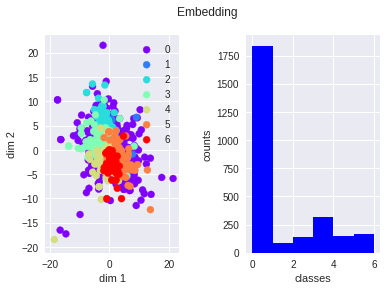

-3.921404 2.3059585 3.4431725 5.406965 -0.62931156 -5.0656075 -2.363378 
1.1714827 -5.2578306 -5.4527335 -2.3398986 5.7612514 3.4511454 6.398634 
-1.0277705 -1.6135563 -1.2451955 1.0653692 2.5405173 -0.38695967 2.1439664 
4.519724 -6.9653444 -8.139528 -6.9151096 5.979723 7.665482 8.090888 
-2.0058486 1.0540334 1.6397109 2.7458293 -0.16882175 -2.537897 -1.052541 
0.4160614 3.2890835 3.0564098 -0.013240337 -4.2437305 -0.96131766 -4.1520514 
2.5661247 1.1290311 0.30122852 -3.1198783 -2.806077 2.1960049 -1.7402307 
-4.36191 6.151705 7.3029723 6.583188 -5.075111 -7.1558886 -7.09766 
-5.7234206 -0.04607743 1.721871 7.3505635 3.2431283 -5.9464083 0.80131763 
-1.4119813 3.8682127 4.181392 2.4286885 -3.9322658 -3.112452 -4.6360054 


In [131]:
mydataset="cora"
printEmbedding = "result_train" # "result_train" "result_test" "modification_train" " modification_test"
mytrain(mydataset, printEmbedding)
plot2DEmbedding("embedding","embedding_labels")
!head ./embedding


len(y): 140
labels shape:
(2708, 7)
len(idx_train) 140
len(idx_val) 500
len(idx_test) 1000
Epoch: 0001 train_loss= 1.95370 train_acc= 0.12143 val_loss= 1.95064 val_acc= 0.22000 time= 0.24185
Epoch: 0051 train_loss= 1.15721 train_acc= 0.56429 val_loss= 1.32579 val_acc= 0.47400 time= 0.03019
Early stopping...
Optimization Finished!
Test set results: cost= 1.28859 accuracy= 0.52400 time= 0.02323


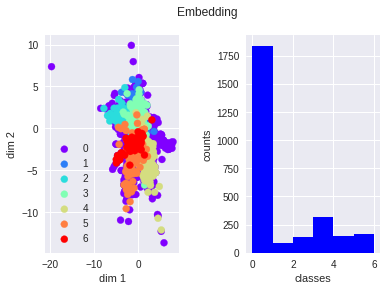

0.2168192 2.577123 0.63610595 2.2211442 -1.8616164 -2.1298335 -1.3539732 
3.1051836 -6.1332207 -4.7139874 -5.053936 5.272733 4.105011 1.2184668 
2.0678995 -3.4101143 -2.9227104 -2.7881427 3.0110893 2.1915588 0.4885621 
5.366349 -0.79077244 -4.9963627 -0.33332035 1.8349693 -0.79234487 -2.5908742 
-0.9615947 1.9463977 1.4749264 1.6054116 -1.6677725 -1.3090849 -0.39987946 
-3.9888396 1.1711987 3.9012055 0.7474389 -1.7967964 0.11986272 1.6464587 
3.528521 -0.71929514 -3.3492682 -0.3898981 1.3544395 -0.36070892 -1.6081208 
0.44081843 2.7703004 0.5001963 2.4009535 -1.9528364 -2.344771 -1.5704235 
-0.01516239 2.3989887 0.7839014 2.0537074 -1.7834141 -1.9248668 -1.1403086 
-5.700713 0.91254514 5.3309593 0.41618484 -2.0030928 0.78341913 2.7175891 


In [130]:
mydataset="cora"
printEmbedding = "result_test" # "result_train" "result_test" "modification_train" " modification_test"
mytrain(mydataset, printEmbedding)
plot2DEmbedding("embedding","embedding_labels")
!head ./embedding

#### Experiment: 2 unit layer embedding  

We add a 2 unit layer after the first 2 GCN layers, and a  in order to have a 2 dimension embedding. We add after that 2d embedding layer, a 6 unit output layer  as it will be necessary for the training to used the 6 possible target labels. In summary, the GCN has been augmented with a 2 unit layer and a 6 unit layer, the training is based on the output of the last 6 units layer but we extract also the values of the 2 unit layer in order to see a 2 dimension embedding trained with the data.

We show the result of the embedding with the training data and later with the testing data.


len(y): 140
labels shape:
(2708, 7)
len(idx_train) 140
len(idx_val) 500
len(idx_test) 1000
Epoch: 0001 train_loss= 1.95396 train_acc= 0.15000 val_loss= 1.95092 val_acc= 0.23600 time= 0.24009
Epoch: 0051 train_loss= 1.35504 train_acc= 0.37143 val_loss= 1.51659 val_acc= 0.44000 time= 0.03652
Early stopping...
Optimization Finished!
Test set results: cost= 1.32138 accuracy= 0.59500 time= 0.01995


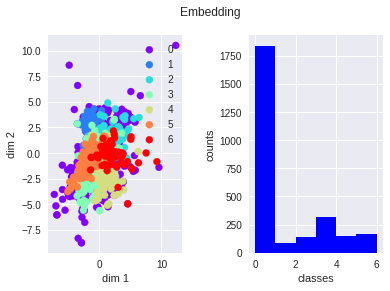

0.107231006 -2.60083 
1.0039409 -3.6626256 
-0.16873932 -2.3423953 
1.9562244 1.773262 
-1.3655217 -2.3514683 
1.1870661 1.0676303 
1.2633357 1.5384977 
-3.1902995 -4.420764 
-0.6364649 -0.93485636 
0.91467124 0.16247842 


In [132]:
mydataset="cora"
printEmbedding = "modification_train" # "result_train" "result_test" "modification_train" " modification_test"
mytrain(mydataset, printEmbedding)
plot2DEmbedding("embedding","embedding_labels")
!head ./embedding


len(y): 140
labels shape:
(2708, 7)
len(idx_train) 140
len(idx_val) 500
len(idx_test) 1000
Epoch: 0001 train_loss= 1.95402 train_acc= 0.13571 val_loss= 1.95046 val_acc= 0.20400 time= 0.28783
Epoch: 0051 train_loss= 1.10390 train_acc= 0.57143 val_loss= 1.34135 val_acc= 0.55400 time= 0.03091
Early stopping...
Optimization Finished!
Test set results: cost= 1.21537 accuracy= 0.62000 time= 0.02355


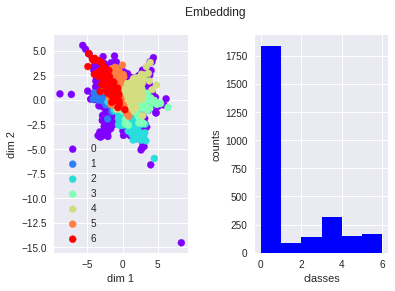

3.0450497 -0.21963781 
2.4253645 1.6885917 
2.7779772 1.235755 
-2.8504817 -2.085433 
2.6604943 0.13665597 
1.8448231 -3.2048783 
-1.3598872 -1.6384299 
3.3900056 0.24097641 
2.1302187 -0.4767413 
2.8974967 -3.2450302 


In [133]:
mydataset="cora"
printEmbedding = "modification_test" # "result_train" "result_test" "modification_train" " modification_test"
mytrain(mydataset, printEmbedding)
plot2DEmbedding("embedding","embedding_labels")
!head ./embedding